In [ ]:
! kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

In [ ]:
! unzip chest-xray-covid19-pneumonia.zip

In [ ]:
import splitfolders

# Define the paths
train_path = 'Data/train'
output_path = 'Data/train_val'  # Output directory for split 

# Split the data with an 80% train and 20% validation split
# It will maintain the subfolder structure (normal, covid, PNEUMONIA)
splitfolders.ratio(train_path, output=output_path, seed=1337, ratio=(.8, .2), group_prefix=None)


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras import layers
import numpy as np
import seaborn as sb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [1]:
import os
# Directories with training pictures
train_corona_dir = os.path.join("Data/train_val/train/COVID19")
train_normal_dir = os.path.join("Data/train_val/train/NORMAL")
train_pneumonia_dir = os.path.join("Data/train_val/train\PNEUMONIA")


train_corona_names = os.listdir(train_corona_dir)
train_normal_names = os.listdir(train_normal_dir)
train_pneumonia_names  = os.listdir(train_pneumonia_dir)

In [2]:
print("train_corona", len(train_corona_names))
print("train_normal", len(train_normal_names))
print("train_pneumonia", len(train_pneumonia_names))

train_corona 368
train_normal 1012
train_pneumonia 2734


Covid Patients


<Figure size 2000x2000 with 0 Axes>

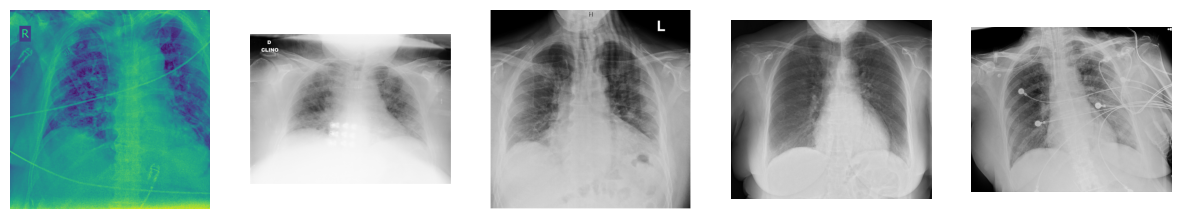

Normal Patients


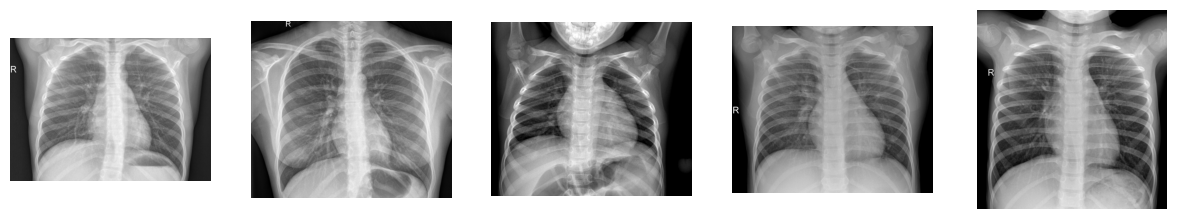

Pneumonia Patients


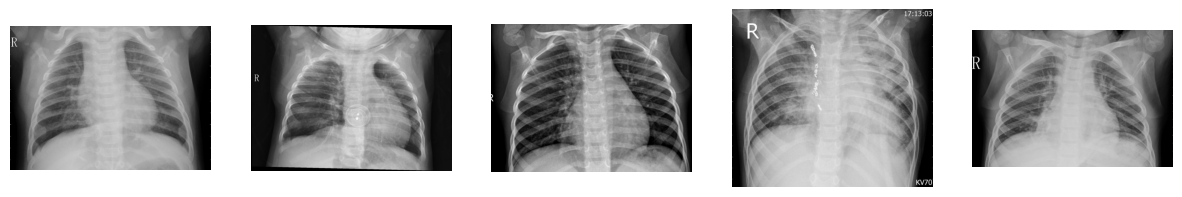

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Visualize some training pictures
nrows = 5
ncols = 5
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 5

next_corona_pix = [os.path.join(train_corona_dir, fname) 
    for fname in train_corona_names[0:pic_index]]

next_normal_pix = [os.path.join(train_normal_dir, fname) 
    for fname in train_normal_names[0:pic_index]]

next_pnuemonia_pix = [os.path.join(train_pneumonia_dir, fname) 
    for fname in train_pneumonia_names[0:pic_index]]

fig=plt.figure(figsize=(15, 15))
print("Covid Patients")
for i,img_path in enumerate(next_corona_pix):
  fig.add_subplot(nrows, ncols, i+1)
  plt.axis("Off")
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()  

fig=plt.figure(figsize=(15, 15))
print("Normal Patients")
for i,img_path in enumerate(next_normal_pix):
  fig.add_subplot(nrows, ncols, i+1)
  plt.axis("Off")
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

fig=plt.figure(figsize=(15, 15))
print("Pneumonia Patients")
for i,img_path in enumerate(next_pnuemonia_pix):
  fig.add_subplot(nrows, ncols, i+1)
  plt.axis("Off")
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [10]:
# Define transformations for the training and validation sets
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize all images to 150x150
    transforms.RandomHorizontalFlip(),  # Apply horizontal flip
    transforms.RandomRotation(10),  # Apply random rotations
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
])

val_transforms = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize to the same size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
])

test_transforms = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize to the same size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
])

# Load datasets
train_dataset = datasets.ImageFolder("Data/train_val/train", transform=train_transforms)
val_dataset = datasets.ImageFolder("Data/train_val/val", transform=val_transforms)
test_dataset = datasets.ImageFolder("Data/test", transform=test_transforms)

# DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [11]:
# Check number of classes and images in each dataset
def print_dataset_info(dataset, dataset_name):
    num_classes = len(dataset.classes)
    num_images = len(dataset.imgs)
    print(f"{dataset_name} - Number of classes: {num_classes}")
    print(f"{dataset_name} - Number of images: {num_images}")

# Print information for each dataset
print_dataset_info(train_dataset, "Training Dataset")
print_dataset_info(val_dataset, "Validation Dataset")
print_dataset_info(test_dataset, "Test Dataset")


Training Dataset - Number of classes: 3
Training Dataset - Number of images: 4114
Validation Dataset - Number of classes: 3
Validation Dataset - Number of images: 1030
Test Dataset - Number of classes: 3
Test Dataset - Number of images: 1288


# A CNN Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
names_of_classes = train_dataset.classes
number_of_classes = len(names_of_classes)


import torch
import torch.nn as nn

class ConvNet(nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=4, stride=1, padding=1)
        self.maxPool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout2d(p=0.3)
        self.relu = nn.ReLU()
        
        # Calculate the output size of the feature maps after the final pooling layer
        self.fc1 = nn.Linear(32 * 18 * 18, 512)  # Adjust this size based on the output of the last pooling layer
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)  # Apply ReLU activation after conv1
        x = self.maxPool(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.relu(x)  # Apply ReLU activation after conv2
        x = self.maxPool(x)
        x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.relu(x)  # Apply ReLU activation after conv3
        x = self.maxPool(x)
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

# Instantiate the model with the number of classes
model = ConvNet(num_classes=number_of_classes)

# Print the model architecture
print(model)


ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.3, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


In [22]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer


Epoch 1/10, Train Loss: 0.4190, Train Accuracy: 84.83%
Validation Loss: 0.2643, Validation Accuracy: 89.81%
Epoch 2/10, Train Loss: 0.4022, Train Accuracy: 85.85%
Validation Loss: 0.2957, Validation Accuracy: 89.61%
Epoch 3/10, Train Loss: 0.3437, Train Accuracy: 88.11%
Validation Loss: 0.2383, Validation Accuracy: 91.65%
Epoch 4/10, Train Loss: 0.3277, Train Accuracy: 88.53%
Validation Loss: 0.2701, Validation Accuracy: 90.68%
Epoch 5/10, Train Loss: 0.3046, Train Accuracy: 88.87%
Validation Loss: 0.2273, Validation Accuracy: 92.23%
Epoch 6/10, Train Loss: 0.2800, Train Accuracy: 89.40%
Validation Loss: 0.2251, Validation Accuracy: 90.97%
Epoch 7/10, Train Loss: 0.2923, Train Accuracy: 89.26%
Validation Loss: 0.2335, Validation Accuracy: 91.26%
Epoch 8/10, Train Loss: 0.2712, Train Accuracy: 90.13%
Validation Loss: 0.2151, Validation Accuracy: 92.14%
Epoch 9/10, Train Loss: 0.2491, Train Accuracy: 91.44%
Validation Loss: 0.1923, Validation Accuracy: 93.50%
Epoch 10/10, Train Loss: 0.2

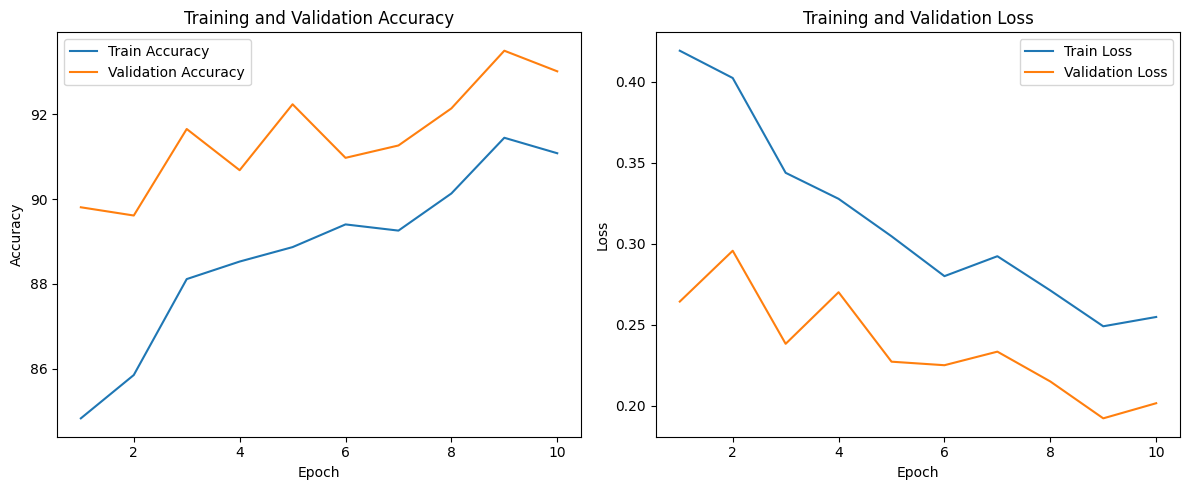

In [25]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    
    # Lists to store accuracy and loss values
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_accuracy = 100 * correct_train / total_train
        
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        
        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = 100 * correct_val / total_val
        
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%")
        print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%")
    
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu')


In [26]:
torch.save(model.state_dict(), 'convnet_model.pth')

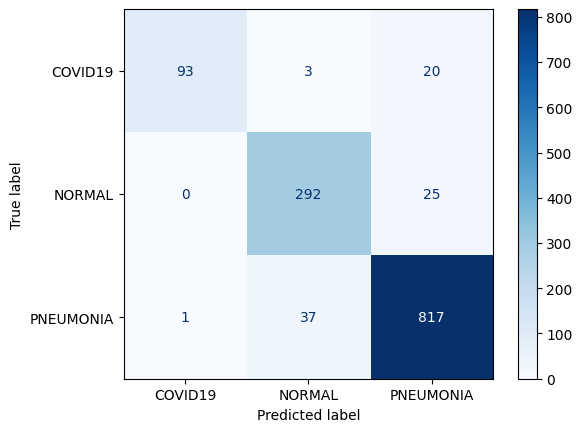

              precision    recall  f1-score   support

     COVID19       0.99      0.80      0.89       116
      NORMAL       0.88      0.92      0.90       317
   PNEUMONIA       0.95      0.96      0.95       855

    accuracy                           0.93      1288
   macro avg       0.94      0.89      0.91      1288
weighted avg       0.93      0.93      0.93      1288



In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def evaluate_model(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(number_of_classes)))
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names_of_classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=names_of_classes))

# Evaluate the model on the test dataset
evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')


# Hyperparameter Tuning with Optuna

In [37]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score

# Define the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ConvNet(nn.Module):
    def __init__(self, num_classes, activation_function, dropout_rate):
        super(ConvNet, self).__init__()
        self.activation_function = activation_function
        self.dropout_rate = dropout_rate
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=4, stride=1, padding=1)
        self.maxPool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout2d(p=self.dropout_rate)
        
        if self.activation_function == 'relu':
            self.activation = nn.ReLU()
        elif self.activation_function == 'sigmoid':
            self.activation = nn.Sigmoid()
        
        self.fc1 = nn.Linear(32 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

def objective(trial):
    # Hyperparameters to optimize
    activation_function = trial.suggest_categorical('activation_function', ['relu'])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.3, 0.2])
    lr = trial.suggest_categorical('lr', [0.0005, 0.005])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
    num_epochs = trial.suggest_categorical('num_epochs', [5, 10])
    batch_size = trial.suggest_categorical('batch_size', [ 32, 64])
    
    # Define the model
    model = ConvNet(num_classes=number_of_classes, activation_function=activation_function, dropout_rate=dropout_rate)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Load datasets with suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Train the model
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_accuracy = 100 * correct_val / total_val
    
    return epoch_val_accuracy  # Return the validation accuracy for optimization

def optimize_hyperparameters():
    study = optuna.create_study(direction='maximize')  # Maximize accuracy
    study.optimize(objective, n_trials=20)  # Number of trials

    # Print the best trial
    print(f"Best trial: {study.best_trial.params}")
    print(f"Best validation accuracy: {study.best_value:.2f}%")

# Run the hyperparameter optimization
optimize_hyperparameters()


[I 2024-09-18 07:38:50,400] A new study created in memory with name: no-name-6e434516-40ee-4e0c-bae4-de6b3fae08b0
[I 2024-09-18 07:59:20,671] Trial 0 finished with value: 66.40776699029126 and parameters: {'activation_function': 'relu', 'dropout_rate': 0.3, 'lr': 0.0005, 'optimizer': 'sgd', 'num_epochs': 10, 'batch_size': 64}. Best is trial 0 with value: 66.40776699029126.
[I 2024-09-18 08:09:30,796] Trial 1 finished with value: 66.40776699029126 and parameters: {'activation_function': 'relu', 'dropout_rate': 0.3, 'lr': 0.0005, 'optimizer': 'sgd', 'num_epochs': 5, 'batch_size': 64}. Best is trial 0 with value: 66.40776699029126.
[I 2024-09-18 08:25:23,965] Trial 2 finished with value: 90.77669902912622 and parameters: {'activation_function': 'relu', 'dropout_rate': 0.2, 'lr': 0.005, 'optimizer': 'adam', 'num_epochs': 10, 'batch_size': 64}. Best is trial 2 with value: 90.77669902912622.
[I 2024-09-18 08:39:40,071] Trial 3 finished with value: 94.66019417475728 and parameters: {'activati

Best trial: {'activation_function': 'relu', 'dropout_rate': 0.3, 'lr': 0.0005, 'optimizer': 'adam', 'num_epochs': 10, 'batch_size': 32}
Best validation accuracy: 94.66%


## FIRST PART: WITHOUT TUNING THE PRE-TRAINED MODEL

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# number of classes
classes = 3

x = Flatten()(vgg.output)
prediction = Dense(classes, activation = 'softmax')(x)

# create a model 
VGG_model = Model(inputs = vgg.input, outputs = prediction)

# view the structure of the model
VGG_model.summary()

# the model what cost and optimization method to use
VGG_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=["accuracy"]
)



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [ ]:
VGG_model.evaluate(test_set)

11/11 [==============================] - 26s 2s/step - loss: 1.0451 - accuracy: 0.2803


[1.045066237449646, 0.2802795171737671]

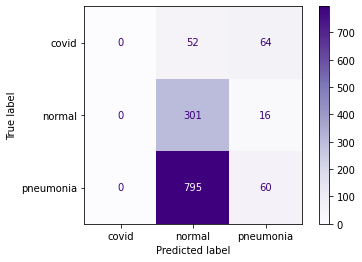

In [ ]:
# CONFUSION MATRIX
VGG_pred = VGG_model.predict(test_set)
VGG_pred = np.argmax(VGG_pred,axis=1)
VGG_test = test_set.classes

VGG_cm = confusion_matrix(VGG_test, VGG_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = VGG_cm, display_labels = ["covid", "normal", "pneumonia"])
disp.plot(cmap = plt.cm.Purples)
plt.show()

In [ ]:
# add preprocessing layer to the front of resnet
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
  layer.trainable = False

# number of classes
classes = 3
  
x = Flatten()(resnet.output)
prediction = Dense(classes, activation='softmax')(x)

# create a model 
ResNet_model = Model(inputs=resnet.input, outputs=prediction)

# view the structure of the model
ResNet_model.summary()

# the model what cost and optimization method to use
ResNet_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=["accuracy"]
)


94781440/94765736 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizati

In [ ]:
ResNet_model.evaluate(test_set)

11/11 [==============================] - 28s 2s/step - loss: 1.4693 - accuracy: 0.0901


[1.4693206548690796, 0.09006211161613464]

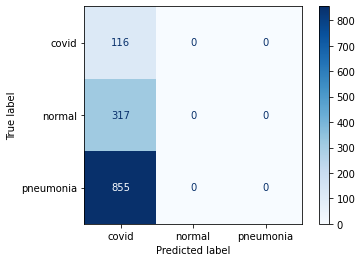

In [ ]:
# CONFUSION MATRIX
ResNet_pred = ResNet_model.predict(test_set)
ResNet_pred = np.argmax(ResNet_pred,axis=1)
ResNet_test = test_set.classes

ResNet_cm = confusion_matrix(ResNet_test, ResNet_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = ResNet_cm, display_labels = ["covid", "normal", "pneumonia"])
disp.plot(cmap = plt.cm.Blues)
plt.show()

### PART 2: TUNING THE PRE-TRAINED MODEL


In [ ]:
########################## VGG16 TRANSFER LEARNING ##########################
'''
  VGG16 
  TRANSFER 
  LEARNING
  WITH
  TUNING
'''
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# train existing weights of the last 3 layers
for layer in vgg.layers[:len(vgg.layers)-3]:
  layer.trainable = False

# number of classes
classes = 3

# our layers 
x = Flatten()(vgg.output)
x = layers.Dense(512, activation = "relu")(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

x = Flatten()(vgg.output)
x = layers.Dense(256, activation = "relu")(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

x = Flatten()(vgg.output)
x = layers.Dense(128, activation = "relu")(x)

prediction = Dense(classes, activation = 'softmax')(x)

# create a model object'''
VGG_model2 = Model(inputs = vgg.input, outputs = prediction)

# view the structure of the model
VGG_model2.summary()

# the model what cost and optimization method to use
VGG_model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=["accuracy"]
)

# fit the model
VGG_model_fit = VGG_model2.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [ ]:
VGG_model2.evaluate(test_set)

11/11 [==============================] - 26s 2s/step - loss: 0.2076 - accuracy: 0.9169


[0.20760619640350342, 0.9169254899024963]

************* VGG16 Model With Tuning ******************


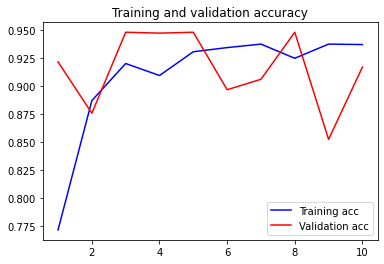

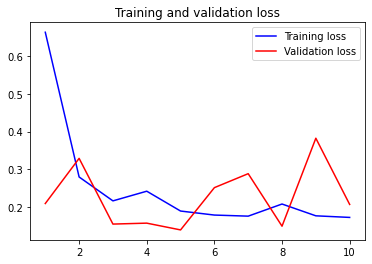

In [ ]:
# PLOT ACCURACY AND LOSS
acc = VGG_model_fit.history['accuracy']
val_acc = VGG_model_fit.history['val_accuracy']
loss = VGG_model_fit.history['loss']
val_loss = VGG_model_fit.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

print("************* VGG16 Model With Tuning ******************")
plt.show()

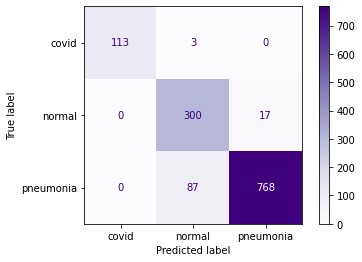

In [ ]:
# CONFUSION MATRIX
VGG_pred2 = VGG_model2.predict(test_set)
VGG_pred2 = np.argmax(VGG_pred2,axis=1)
VGG_test2 = test_set.classes

VGG_cm2 = confusion_matrix(VGG_test2, VGG_pred2)

VGG_cm2_disp = ConfusionMatrixDisplay(confusion_matrix = VGG_cm2, display_labels = ["covid", "normal", "pneumonia"])
VGG_cm2_disp.plot(cmap = plt.cm.Purples)
plt.show()

In [ ]:
########################## RESNET50 TRANSFER LEARNING ##########################
'''
  RESNET50 
  TRANSFER 
  LEARNING
  WITH
  TUNING
'''

# add preprocessing layer to the front of resnet
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers[:len(resnet.layers)-3]:
  layer.trainable = False

# number of classes
classes = 3
  
# our layers 
x = Flatten()(resnet.output)
x = layers.Dense(512, activation = "relu")(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

x = Flatten()(resnet.output)
x = layers.Dense(256, activation = "relu")(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

x = Flatten()(resnet.output)
x = layers.Dense(128, activation = "relu")(x)

prediction = Dense(classes, activation = 'softmax')(x)

# create a model object
ResNet_model = Model(inputs=resnet.input, outputs=prediction)

# view the structure of the model
ResNet_model.summary()

# the model what cost and optimization method to use
ResNet_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=["accuracy"]
)

# fit the model
ResNet_model_fit = ResNet_model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
ResNet_model.evaluate(test_set)

11/11 [==============================] - 29s 2s/step - loss: 0.5447 - accuracy: 0.7849


[0.5446959733963013, 0.784937858581543]

************* ResNet50 Model With Tuning ******************


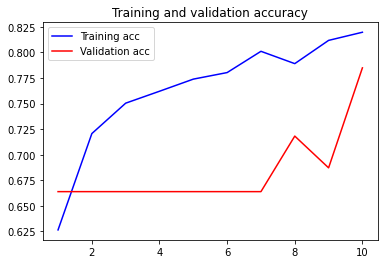

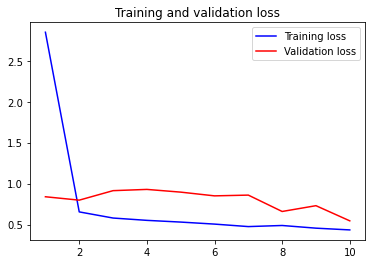

In [ ]:
# PLOT ACCURACY AND LOSS 
acc = ResNet_model_fit.history['accuracy']
val_acc = ResNet_model_fit.history['val_accuracy']
loss = ResNet_model_fit.history['loss']
val_loss = ResNet_model_fit.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

print("************* ResNet50 Model With Tuning ******************")
plt.show()

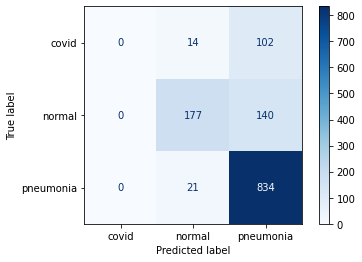

In [ ]:
# CONFUSSION MATRIX
ResNet2_pred = ResNet_model.predict(test_set)
ResNet2_pred = np.argmax(ResNet2_pred,axis=1)
ResNet2_test = test_set.classes

ResNet_cm_2 = confusion_matrix(ResNet2_test, ResNet2_pred)

ResNet_cm_2_disp = ConfusionMatrixDisplay(confusion_matrix = ResNet_cm_2, display_labels = ["covid", "normal", "pneumonia"])
ResNet_cm_2_disp.plot(cmap = plt.cm.Blues)
plt.show()

### EXTRA PART: BUILD OUR OWN CNN MODEL

In [ ]:
model_cnn = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_cnn.summary()

model_cnn.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=["accuracy"]
)


# fit the model
model_cnn_fit = model_cnn.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       7

In [ ]:
model_cnn.evaluate(test_set)

11/11 [==============================] - 25s 2s/step - loss: 0.3909 - accuracy: 0.8160


[0.3908790946006775, 0.8159937858581543]

************* CNN Model With 0.2 Dropout ******************


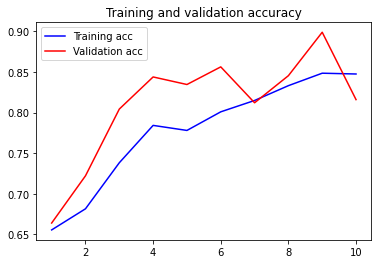

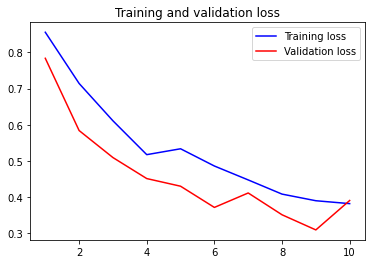

In [ ]:
# PLOT ACCURACY AND LOSS
acc = model_cnn_fit.history['accuracy']
val_acc = model_cnn_fit.history['val_accuracy']
loss = model_cnn_fit.history['loss']
val_loss = model_cnn_fit.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

print("************* CNN Model With 0.2 Dropout ******************")
plt.show()

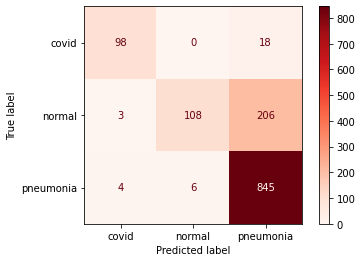

In [ ]:
# CONFUSSION MATRIX
CNN_pred = model_cnn.predict(test_set)
CNN_pred = np.argmax(CNN_pred,axis=1)
CNN_test = test_set.classes

CNN_cm = confusion_matrix(CNN_test, CNN_pred)

CNN_cm_disp = ConfusionMatrixDisplay(confusion_matrix = CNN_cm, display_labels = ["covid", "normal", "pneumonia"])
CNN_cm_disp.plot(cmap = plt.cm.Reds)
plt.show()